In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Data Cleaning

Need to remove the unusable and redundant columns

In [2]:
df = pd.read_csv('all_seasons.csv', index_col=0)
df.reset_index(inplace=True, drop = True)
df.shape

(4095, 236)

### Columns to delete:
- gf = gols for
- ga = goals against
- gf_opp = goals or the opponent
- ga_opp = goals against the opponent. 
- poss = possession, it has got x, y in the merging, will drop one and use the other. 
- Will remove ga and ga_opp as the columns are redundant. 

In [3]:
cols_todel = ['ga','match report_x','match report_y','date_opp','time_opp','comp_opp','round_opp','day_opp','venue_opp','result_opp','ga_opp','opponent_opp','xg', 'xg_y', 'match report_opp','poss_y', 'captain','referee','notes', 'attendance']
df.drop(cols_todel, axis=1, inplace=True)
df.shape

(4095, 216)

Some gf and gf_opp parts have "()" in them for aggregate score. I will have to ensure they are processed correctly, I will take the value outside of the parenthesis, as that is the match sore.

In [4]:
df.loc[df["gf"].str.contains(" "),'gf'] = df["gf"].str[0] # if the Score column starts with "(", then grab the first from left char.
df.loc[df["gf_opp"].str.contains(" "),'gf_opp'] = df["gf_opp"].str[0]

## Encoding string columns

- First clean the opponent column before encoding it, the namings are not consistent


In [5]:
len(df['opponent'].unique())

523

In [6]:
df['opponent'] = df['opponent'].apply(lambda x: x[3:].lstrip() if x[0].islower() else x)  # If the format of the name starts with small letters, that is the country code. 
len(df['opponent'].unique())

459

Making team names consistent. 

In [7]:
df['opponent'] = df['opponent'].apply(lambda x:'Atletico Madrid' if x == 'Atlético Madrid' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Bayer Leverkusen' if x == 'Leverkusen' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Eintracht Frankfurt' if x == 'Eint Frankfurt' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Internazionale' if x == 'Inter' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Paris Saint Germain' if x == 'Paris S-G' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Red Bull Salzburg' if x == 'RB Salzburg' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Shakhtar Donetsk' if x == 'Shakhtar' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Tottenham Hotspur' if x == 'Tottenham' else x)
df['opponent'] = df['opponent'].apply(lambda x:'Viktoria Plzen' if x == 'Viktoria Plzeň' else x)
len(df['opponent'].unique())

459

Checking the "team" column, the way team and opponent names are written must be consistent. 

In [8]:
print(len(df['team'].unique()))
df['team'].unique()

52


array(['Chelsea', 'Manchester City', 'Real Madrid', 'Paris Saint Germain',
       'Bayern Munich', 'Liverpool', 'Porto', 'Dortmund', 'Juventus',
       'Barcelona', 'Sevilla', 'RB Leipzig', 'Atalanta', 'Lazio',
       'Atletico Madrid', 'Monchengladbach', 'Manchester United',
       'Club Brugge', 'Shakhtar Donetsk', 'Ajax', 'Internazionale',
       'Krasnodar', 'Red Bull Salzburg', 'Dynamo Kyiv',
       'Lokomotiv Moscow', 'Olympiacos', 'Istanbul Basaksehir',
       'Marseille', 'Midtjylland', 'Rennes', 'Zenit', 'Ferencvaros',
       'Villarreal', 'Benfica', 'Lille', 'Sporting CP',
       'Sheriff Tiraspol', 'Young Boys', 'Wolfsburg', 'Milan', 'Malmo',
       'Besiktas', 'Napoli', 'Tottenham Hotspur', 'Eintracht Frankfurt',
       'Bayer Leverkusen', 'Dinamo Zagreb', 'FC Copenhagen',
       'Maccabi Haifa', 'Celtic', 'Viktoria Plzen', 'Rangers'],
      dtype=object)

Now encode the rest of the information rich categorical columns.

In [9]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True)
df["venue_code"] = df["venue"].astype("category").cat.codes
df["opp_code"] = df["opponent"].astype("category").cat.codes #
df['round_code'] = df['round'].astype('category').cat.codes
df['comp_code'] = df['comp'].astype('category').cat.codes
df['formation_code'] = df['formation'].astype('category').cat.codes


df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df["day_code"] = df["date"].dt.dayofweek

df.head()

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,formation,team,season,venue_code,opp_code,round_code,comp_code,formation_code,hour,day_code
0,2020-09-14,20:15,Premier League,Matchweek 1,Mon,Away,W,3,Brighton,3.0,...,4-2-2-2,Chelsea,2020-2021,0,73,12,19,13,20,0
1,2020-09-20,16:30,Premier League,Matchweek 2,Sun,Home,L,0,Liverpool,0.0,...,4-3-3,Chelsea,2020-2021,1,229,23,19,18,16,6
2,2020-09-23,19:45,EFL Cup,Third round,Wed,Home,W,6,Barnsley,6.0,...,4-2-3-1,Chelsea,2020-2021,1,50,66,10,14,19,2
3,2020-09-26,17:30,Premier League,Matchweek 3,Sat,Away,D,3,West Brom,3.0,...,4-2-3-1,Chelsea,2020-2021,0,435,34,19,14,17,5
4,2020-09-29,19:45,EFL Cup,Fourth round,Tue,Away,D,1,Tottenham Hotspur,1.0,...,4-2-3-1,Chelsea,2020-2021,0,395,8,10,14,19,1


## Missing Data
Deleting rows that are missing a lot of stats. Already have very high dimensionality, and not enough data or this many dimensions, so wil remove some of the stat columns. Let us have a visual on the missing values in all the columns. 

(4095, 223)

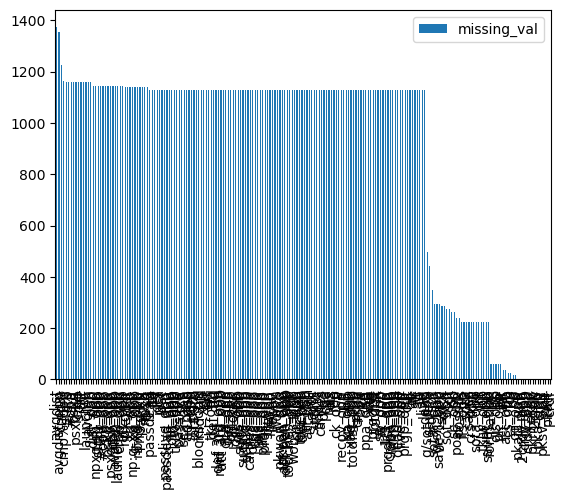

In [10]:
missing = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
missing.rename(columns={0:'missing_val'}, inplace=True)
missing[missing['missing_val']>0].plot.bar()

df.shape

We can see that the number of missing values drops down in a step function. So we delete the columns that have over 300 missing values and the rows for anything less than that. This is the sweet spot as deleting more columns or rows will impact the quality of our data. 
Also, the relationship between various features in football matches is highly (e.g the opponent team) so imputation is not the answer here as it may affect the quality of the data too much.

In [11]:
cols_todel2 = missing[missing['missing_val']>300].index
df.drop(list(cols_todel2), axis=1, inplace=True)
df.shape

(4095, 69)

Of course if one is interested, one can use these columns with the rows that have them, but I choose to have lower dimensionality and more data rows. 

In [12]:
df = df.dropna(axis = 0) #drop rows with missing values
# df = df.reset_index(drop=True)
df.shape # and no missing values.

(3707, 69)

Everything that has to be numeric is already numeric. Let us make a target variable first.

## Setting up the target column

In [13]:
df['result'].value_counts()

W    2128
L     829
D     750
Name: result, dtype: int64

As can be seen from above, the result column is not balanced. Also, according to our brief of predicting if the game is going ot be a win or "not", we will have a binary target column, the result is either a win or loss. Te reason the number of wins is a lot higher than the losses and draws is that these tea have qualified for the Champions League. The qualifying teams win the majority of their games in the domestic leagues as well. 

In [14]:
df = df.sort_values("date")
df=df.reset_index(drop=True)

In [15]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0])

venue
Away       0.525323
Home       0.625068
Neutral    0.458333
dtype: float64

In [16]:
df.venue.value_counts() # this is not balanced. Have to drop the venues that are neutral. It is only 24 rows. 

Away       1856
Home       1827
Neutral      24
Name: venue, dtype: int64

In [17]:
df = df.loc[df['venue']!='Neutral'] # dropping venue = neutral. 
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # So in %62 of the cases, the team wins their home games, as opposed to onl 52% of their away games. 
# This is our benchmark.

venue
Away    0.525323
Home    0.625068
dtype: float64

In [18]:
df['target'] = (df['result'] == "W").astype("int")

# Prediction Using Machine Learning

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [20]:
predictors = ["venue_code", "opp_code", "hour", "day_code", 'round_code', 'comp_code','formation_code'] # initial predictors. 

In [21]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1, class_weight='balanced')

train = df[df['date']< "2022-08-15"] # Using 70% of the rows for training and 30% for testing. cannot do splits since we cannot use future data to predict past games. 
test = df[df['date']> "2022-08-15"]

rf.fit(train[predictors],train['target'])

predictions = rf.predict(test[predictors])

print(train.shape)
print(test.shape)

accuracy_score(test["target"],predictions)

print('accuracy_score =' ,accuracy_score(test["target"],predictions))

(2759, 70)
(920, 70)
accuracy_score = 0.6141304347826086


In [22]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,160,222
1,133,405


Accuracy score here is not a good measure, we use precision score as we have false positives and false negatives. 0 is a loss and 1 is a win. 

In [23]:
from sklearn.metrics import precision_score

precision_score(test["target"], predictions, average = None) # this shows that we predict %46 for away games and %62 for home games. We need to improve on this.

array([0.54607509, 0.64593301])

In [24]:
precision_score(test["target"], predictions, average = 'weighted')

0.6044702655612444

#### Feature engineering
We need to use the rest of the statistics we have to see if we can improve our model. Hence we introduce rolling averages of statistics from previous games as prediction metrics. We have to be careful not to feed any information to the model for predicting a game when we won't have the information. Yu cannot have goals for in the predictors, as that information is known after the game! 

In [25]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3,closed="left").mean() # closed = left -> to avoid data leakage from future matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group

In [26]:
def make_predictions(data, predictors):
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1)

    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]

    rf.fit(train[predictors],train['target'])

    predictions = rf.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    return combined, precision_weight, precision_raw, rf.feature_importances_, rf

### Trying some features based on domain knowledge.

In [27]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,new_cols))
df_rolling = df_rolling.droplevel('team')

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, predictors+new_cols)

print("The raw precision [Away, Home] is:",precision_raw)
print("The weighted precision is:", precision_weight)

The raw precision [Away, Home] is: [0.55438596 0.64761905]
The weighted precision is: 0.6088992974238876


In [28]:
df_rolling.shape

(3533, 80)

In [29]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # What we get by predicting home wins, i.e. %62 of the home games are won and %52 of the away games. 

venue
Away    0.525323
Home    0.625068
dtype: float64

We are already over the benchmark with the above stats, but we will try and improve. 

In [30]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,158,222
1,127,408


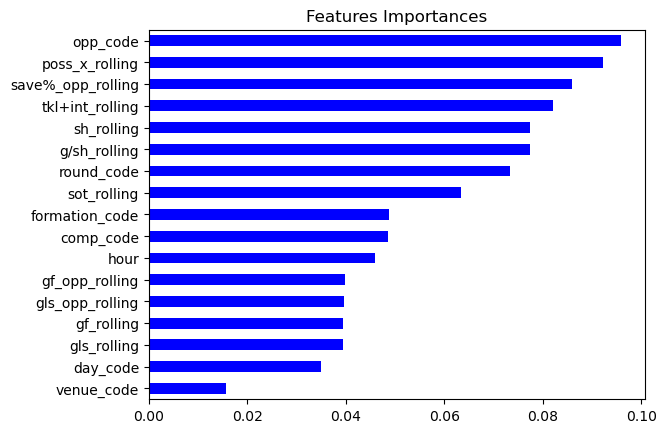

In [31]:
importance = pd.Series(data=importances,
                        index=  predictors+new_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

### Using all the columns by getting a rolling average for them. 

In [32]:
predictors

['venue_code',
 'opp_code',
 'hour',
 'day_code',
 'round_code',
 'comp_code',
 'formation_code']

In [33]:
df.shape

(3683, 70)

In [34]:
#num_cols = df.select_dtypes('number').columns

In [35]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]



rolling_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,rolling_cols))
df_rolling = df_rolling.droplevel('team')

all_cols = rolling_cols+predictors

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, all_cols)

print(precision_raw)
print(precision_weight)

[0.57142857 0.63531114]
0.6087806762761093


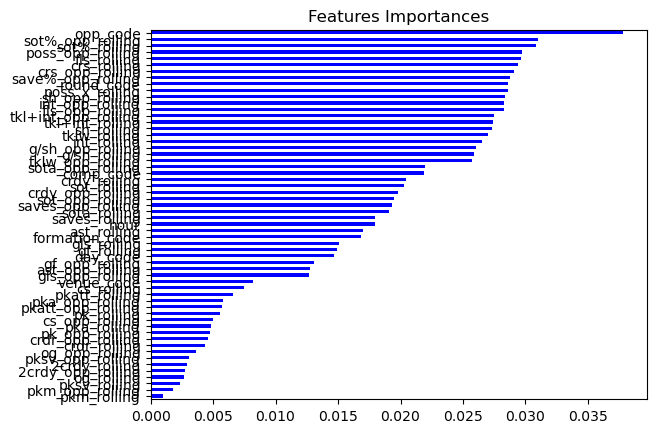

In [36]:
importance = pd.Series(data=importances,
                        index=  all_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

### We rank the features based on their importance, and then we discard the east important ones. 

In [37]:
data ={'imp_vals':importances}
imp_df = pd.DataFrame(data=data, index=all_cols)
imp_df.sort_values(by = 'imp_vals')

,imp_vals
pkm_rolling,0.001020
pkm_opp_rolling,0.001781
pksv_rolling,0.002350
og_rolling,0.002691
2crdy_opp_rolling,0.002764
2crdy_rolling,0.002913
pksv_opp_rolling,0.003062
og_opp_rolling,0.003620
crdr_rolling,0.004342
crdr_opp_rolling,0.004579


In [38]:
predictors3 = imp_df.loc[imp_df['imp_vals']>0.005].index # Selecting from the chosen features, and removing the east important ones. 
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)

print(precision_raw)
print(precision_weight)

pd.crosstab(index=combined["actual"], columns=combined["predicted"])

[0.59276018 0.64121037]
0.6210889827437784


predicted,0,1
actual,,
0,131,249
1,90,445


In [39]:
combined

,actual,predicted
2808,1,1
2841,1,1
2884,1,1
2916,1,1
2943,1,1
...,...,...
2957,0,0
3047,0,0
3112,0,0
3211,0,0


Hence we have beaten the benchmark using selected features. Using the sequential feature selection to see if we can improve the score did not yield any results that could beat the above. 

## More feature Engineering with summation. 

In [40]:
df_rolling["fls_rolling+sot%_rolling"] = df_rolling["fls_rolling"]+df_rolling['sot%_rolling']
predictors3 = list(predictors3) + ["fls_rolling+sot%_rolling"] # Adding two columns together


In [41]:
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)
print(precision_raw)
print(precision_weight)
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

[0.57399103 0.63583815]
0.6101530080140716


predicted,0,1
actual,,
0,128,252
1,95,440


Marginal improvement

In [42]:
selected_columns = ['team','venue','opponent','venue_code','opp_code','hour','day_code',
 'gf_rolling','gls_rolling','sh_rolling','sot_rolling','sot%_rolling','g/sh_rolling',
 'pk_rolling','pkatt_rolling','gf_opp_rolling','gls_opp_rolling','sh_opp_rolling','sot_opp_rolling',
 'sot%_opp_rolling','g/sh_opp_rolling','pk_opp_rolling','pkatt_opp_rolling','sota_rolling',
 'saves_rolling','cs_rolling','pka_rolling','pksv_rolling','pkm_rolling','sota_opp_rolling',
 'saves_opp_rolling','save%_opp_rolling','cs_opp_rolling','pka_opp_rolling','pksv_opp_rolling',
 'pkm_opp_rolling','ast_rolling','ast_opp_rolling','crs_rolling','crs_opp_rolling','tklw_rolling',
 'int_rolling','tkl+int_rolling','tklw_opp_rolling','int_opp_rolling','tkl+int_opp_rolling',
 'poss_x_rolling','poss_opp_rolling','crdy_rolling','crdr_rolling','2crdy_rolling', 'fls_rolling',
 'og_rolling','crdy_opp_rolling','crdr_opp_rolling','2crdy_opp_rolling','fls_opp_rolling',
 'og_opp_rolling','fls_rolling+sot%_rolling']

In [43]:
len(df[df['season']=='2022-2023']['team'].unique())

31

In [44]:
df_rolling [df_rolling['season']=='2022-2023']['team'].unique()

array(['Ajax', 'Atletico Madrid', 'Barcelona', 'Bayer Leverkusen',
       'Bayern Munich', 'Benfica', 'Celtic', 'Chelsea', 'Club Brugge',
       'Dinamo Zagreb', 'Dortmund', 'Eintracht Frankfurt',
       'FC Copenhagen', 'Internazionale', 'Juventus', 'Liverpool',
       'Manchester City', 'Marseille', 'Milan', 'Napoli',
       'Paris Saint Germain', 'Porto', 'RB Leipzig', 'Rangers',
       'Real Madrid', 'Red Bull Salzburg', 'Sevilla', 'Shakhtar Donetsk',
       'Sporting CP', 'Tottenham Hotspur', 'Viktoria Plzen'], dtype=object)

In [45]:
df[['team','opponent']]

,team,opponent
0,Club Brugge,Charleroi
1,Krasnodar,Ufa
2,Zenit,Rotor Volgograd
3,Lokomotiv Moscow,Rubin Kazan
4,Krasnodar,Loko Moscow
...,...,...
3702,Juventus,Roma
3703,Club Brugge,Benfica
3704,Dortmund,Chelsea
3705,Benfica,Club Brugge


In [46]:
df['round'].unique()

array(['Regular season', 'Matchweek 1', 'Matchweek 2', 'Matchweek 3',
       'Matchweek 4', 'Matchweek 5', 'Matchweek 6', 'First round',
       'Matchweek 7', 'Matchweek 8', 'Play-off round', 'Third round',
       'Matchweek 9', 'Fourth round', 'Matchweek 10', 'Matchweek 11',
       'Group stage', 'Matchweek 12', 'Matchweek 13', 'Matchweek 14',
       'Matchweek 15', 'Matchweek 16', 'Matchweek 17', 'Matchweek 18',
       'Matchweek 19', 'Second round', 'Quarter-finals', 'Semi-finals',
       'Third round proper', 'Matchweek 20', 'Round of 32',
       'Matchweek 21', 'Fourth round proper', 'Round of 16',
       'Matchweek 22', 'Matchweek 23', 'Matchweek 24',
       'Fifth round proper', 'Matchweek 25', 'Matchweek 26',
       'Matchweek 27', 'Matchweek 29', 'Matchweek 28', 'Matchweek 33',
       'Matchweek 30', 'Matchweek 31', 'Matchweek 32',
       'Championship round', 'Matchweek 35', 'Matchweek 36',
       'Matchweek 34', 'Final', 'Matchweek 38', 'Play-off I',
       'Matchweek 39', '

In [47]:
df['comp'].unique()

array(['First Division A', 'Premier League', 'Ligue 1', 'Superliga',
       'DFB-Pokal', 'Eredivisie', 'Bundesliga', 'Süper Lig',
       'Primeira Liga', 'Serie A', 'La Liga', 'Champions Lg', 'EFL Cup',
       'Copa del Rey', 'FA Cup', 'Coppa Italia', 'Coupe de France',
       'Europa Lg', 'Swiss Super League', 'Supercopa de España', '1. HNL',
       'Premiership'], dtype=object)

In [48]:
df[df['comp']=='Champions Lg']

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,team,season,venue_code,opp_code,round_code,comp_code,formation_code,hour,day_code,target
64,2020-09-22,22:00,Champions Lg,Play-off round,Tue,Home,W,2,PAOK,2.0,...,Krasnodar,2020-2021,1,293,55,3,18,22,1,1
66,2020-09-22,21:00,Champions Lg,Play-off round,Tue,Away,D,0,Slavia Prague,0.0,...,Midtjylland,2020-2021,0,366,55,3,18,21,1,0
67,2020-09-22,22:00,Champions Lg,Play-off round,Tue,Away,W,2,Maccabi Tel Aviv,2.0,...,Red Bull Salzburg,2020-2021,0,244,55,3,20,22,1,1
69,2020-09-23,21:00,Champions Lg,Play-off round,Wed,Away,W,2,Gent,2.0,...,Dynamo Kyiv,2020-2021,0,161,55,3,18,21,2,1
70,2020-09-23,21:00,Champions Lg,Play-off round,Wed,Away,D,3,Molde,3.0,...,Ferencvaros,2020-2021,0,262,55,3,18,21,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,2023-02-22,21:00,Champions Lg,Round of 16,Wed,Home,D,1,Manchester City,1.0,...,RB Leipzig,2022-2023,1,250,58,3,14,21,2,0
3703,2023-03-07,20:00,Champions Lg,Round of 16,Tue,Away,L,1,Benfica,1.0,...,Club Brugge,2022-2023,0,57,58,3,9,20,1,0
3704,2023-03-07,20:00,Champions Lg,Round of 16,Tue,Away,L,0,Chelsea,0.0,...,Dortmund,2022-2023,0,93,58,3,12,20,1,0
3705,2023-03-07,20:00,Champions Lg,Round of 16,Tue,Home,W,5,Club Brugge,5.0,...,Benfica,2022-2023,1,100,58,3,14,20,1,1


In [62]:
import xgboost as xgb

XGB_model = xgb.XGBClassifier( 
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      reg_lambda = .5,
                      max_depth=5, 
                      gamma=5,
                      seed=82)


In [63]:
def make_xgb_predictions(XGB_model, data, predictors):


    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]
    
    eval_set = [(train[predictors], train['target']), (test[predictors], test['target'])]

    XGB_model.fit(train[predictors],train['target'], eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

    predictions = XGB_model.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    return combined, precision_weight, precision_raw, XGB_model.feature_importances_, XGB_model

In [64]:
combined, precision_weight, precision_raw, importances,XGB_model = make_xgb_predictions (XGB_model,df_rolling, predictors3)
print(precision_raw)
print(precision_weight)
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

c:\ProgramData\Anaconda3\envs\football_proj\Lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBoostError: [11:51:08] D:\bld\xgboost-split_1667849704519\work\src\metric\multiclass_metric.cu:34: Check failed: label_error >= 0 && label_error < static_cast<int32_t>(n_class): MultiClassEvaluation: label must be in [0, num_class), num_class=1 but found 1 in label